This code is adapted from [this tutorial](https://github.com/planet-os/notebooks/blob/master/aws/era5-s3-via-boto.ipynb) on accessing ERA5 data stored on a public S3 bucket as a part of Amazon Web Services (AWS) and [this tutorial](https://github.com/pangeo-data/pangeo/blob/master/notebooks/newmann_ensemble_meteorology.ipynb) that analyzes a multi-model ensemble using dask and xarray.


Using [ERA5](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5) data downloaded from a public S3 bucket on AWS, we will utilize [xarray](http://xarray.pydata.org/en/stable/) and [dask](https://docs.dask.org/en/latest/) to plot and analyze variables.

ERA5 data is hourly at a gridded resolution of 30 km. ERA5 combines vast amounts of historical observations into global estimates using advanced modelling and data assimilation systems to provide estimates of large number of atmospheric, land and oceanic climate variables.

**Load python libraries**

In [1]:
%matplotlib inline
import boto3
import botocore
import datetime
import matplotlib.pyplot as plt
import os.path
import xarray as xr
import numpy as np
# import cartopy.crs as ccrs
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
# import matplotlib.ticker as mticker
# from IPython.display import Image, display
from dask.distributed import Client, progress

**Connect to Dask Distributed Cluster**

Set the `memory_limit` parameter in `Client()` if dask doesn't auto detect your memory limit accurately later on in the notebook. You will know this is occurring if processes start to get killed due to memory limit errors.

In [2]:
from dask.distributed import Client
client = Client(processes=True, n_workers=3, memory_limit='8GB')
client

Client Scheduler: tcp://127.0.0.1:40001 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 3 Cores: 48 Memory: 24.00 GB


**Set up access to S3 bucket using `boto3` and a low-level client**

Rather than setting up access key and ID, we will use a low-level client to request data anonymously.

In [3]:
era5_bucket = 'era5-pds'
# No AWS keys required
client = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED))

Let's download main.nc file for the month indicated and use xarray to inspect the metadata relating to the data files.

In [4]:
date = datetime.date(2017,1,1) # update to desired date
prefix = date.strftime('%Y/%m/')

metadata_file = 'main.nc'
metadata_key = prefix + metadata_file
client.download_file(era5_bucket, metadata_key, metadata_file)
ds_meta = xr.open_dataset('main.nc', decode_times=False)
ds_meta.info()

xarray.Dataset {
dimensions:
	lat = 640 ;
	lat_ocean = 501 ;
	lon = 1280 ;
	lon_ocean = 1002 ;
	nv = 2 ;
	time0 = 744 ;
	time1 = 744 ;

variables:
	float32 lat(lat) ;
		lat:standard_name = latitude ;
		lat:long_name = latitude ;
		lat:units = degrees_north ;
	float64 time0(time0) ;
		time0:units = seconds since 1970-01-01 ;
		time0:standard_name = time ;
	float64 time1(time1) ;
		time1:units = seconds since 1970-01-01 ;
		time1:standard_name = time ;
		time1:bounds = time1_bounds ;
	float32 lat_ocean(lat_ocean) ;
		lat_ocean:standard_name = latitude ;
		lat_ocean:long_name = latitude ;
		lat_ocean:units = degrees_north ;
	float32 lon(lon) ;
		lon:standard_name = longitude ;
		lon:long_name = longitude ;
		lon:units = degrees_east ;
	float32 lon_ocean(lon_ocean) ;
		lon_ocean:standard_name = longitude ;
		lon_ocean:long_name = longitude ;
		lon_ocean:units = degrees_east ;
	float32 air_temperature_at_2_metres(time0, lat, lon) ;
		air_temperature_at_2_metres:standard_name = air_temperatu

**Download variables of interest**

Note that each variable for one month is approximately 1 GB, so this takes a minute.

In [5]:
# select variable(s) of interest
# var1 = 'precipitation_amount_1hour_Accumulation'
var2 = 'air_pressure_at_mean_sea_level'
var1 = 'air_temperature_at_2_metres'

var_list = [var1, var2]

for var in var_list:
    # file path patterns for remote S3 objects and corresponding local file
    s3_data_ptrn = '{year}/{month}/data/{var}.nc'
    data_file_ptrn = '{year}{month}_{var}.nc'

    year = date.strftime('%Y')
    month = date.strftime('%m')
    s3_data_key = s3_data_ptrn.format(year=year, month=month, var=var)
    data_file = data_file_ptrn.format(year=year, month=month, var=var)

    if not os.path.isfile(data_file): # check if file already exists
        print("Downloading %s from S3..." % s3_data_key)
        client.download_file(era5_bucket, s3_data_key, data_file)

**Open multiple data files into a single xarray dataset object**

In [6]:
## Open multiple files as a single dataset
file_pattern = '{year}{month}*.nc'
filename_pattern = file_pattern.format(year=year, month=month)

ds = xr.open_mfdataset(filename_pattern, engine='netcdf4', concat_dim='var')
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds.info

ds size in GB 4.88



<bound method Dataset.info of <xarray.Dataset>
Dimensions:                         (lat: 640, lon: 1280, time0: 744, var: 1)
Coordinates:
  * lon                             (lon) float32 0.0 0.2812494 ... 359.718
  * lat                             (lat) float32 89.784874 ... -89.784874
  * time0                           (time0) datetime64[ns] 2017-01-01T07:00:00 ... 2017-02-01T06:00:00
Dimensions without coordinates: var
Data variables:
    air_pressure_at_mean_sea_level  (var, time0, lat, lon) float32 dask.array<shape=(1, 744, 640, 1280), chunksize=(1, 744, 640, 1280)>
    air_temperature_at_2_metres     (var, time0, lat, lon) float32 dask.array<shape=(1, 744, 640, 1280), chunksize=(1, 744, 640, 1280)>
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    title:        "ERA5 forecasts"
    history:      Thu Jul  5 04:01:44 2018: ncatted /data.e1/wrk/s3_out_in/20...>

The `ds.info` output above shows us that there are four dimensions to the data: lat, lon, and time0; and two data variables: air_temperature_at_2_metres, and air_pressure_at_mean_sea_level.

**Spatially subset to Western US**

It is important near the beginning of your analysis to subset as much as possible. That way, when we start computing, we aren't taking up computational space with something we aren't interested in.

In [7]:
ds = ds.sel(lat=slice(50,30), lon=slice(360-140,360-105))
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds.info

ds size in GB 0.05



<bound method Dataset.info of <xarray.Dataset>
Dimensions:                         (lat: 71, lon: 124, time0: 744, var: 1)
Coordinates:
  * lon                             (lon) float32 220.21829 ... 254.81197
  * lat                             (lat) float32 49.882885 ... 30.210762
  * time0                           (time0) datetime64[ns] 2017-01-01T07:00:00 ... 2017-02-01T06:00:00
Dimensions without coordinates: var
Data variables:
    air_pressure_at_mean_sea_level  (var, time0, lat, lon) float32 dask.array<shape=(1, 744, 71, 124), chunksize=(1, 744, 71, 124)>
    air_temperature_at_2_metres     (var, time0, lat, lon) float32 dask.array<shape=(1, 744, 71, 124), chunksize=(1, 744, 71, 124)>
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    title:        "ERA5 forecasts"
    history:      Thu Jul  5 04:01:44 2018: ncatted /data.e1/wrk/s3_out_in/20...>

See how much smaller that is? Now we will do some unit conversions so that our plots make a little more sense.

**Convert units to something more familiar**

In [9]:
# Convert mean sea level pressure units to 'hPa'
ds['air_pressure_at_mean_sea_level'] = ds.air_pressure_at_mean_sea_level/100.0
ds.air_pressure_at_mean_sea_level.attrs['units'] = 'hPa'

# and surface temperature units to 'C'
ds['air_temperature_at_2_metres'] = ds.air_temperature_at_2_metres - 273.15
ds.air_temperature_at_2_metres.attrs['units'] = 'C'

Now let's do some quick analysis - for example taking the average January surface temperature.

**Compute the mean temperature across the time axis**

In [10]:
# calculates the monthly mean along the time dimension
da_temp_mean = ds['air_temperature_at_2_metres'].mean(dim='time0')

The expressions above didn’t actually compute anything. They just build the dask task graph. To do the computations, we call the `compute` method:

In [11]:
%time da_temp_mean = da_temp_mean.compute()

CPU times: user 9.64 s, sys: 1.55 s, total: 11.2 s
Wall time: 51 s


**Plot Average Surface Temperature**

Text(0.5, 1.0, 'January 2017 Mean Temperature')

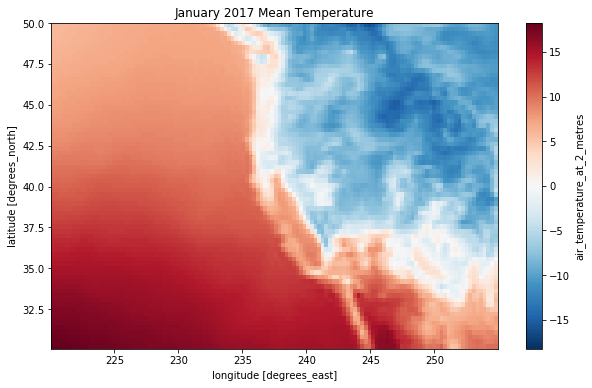

In [12]:
da_temp_mean.plot(figsize=(10, 6))
plt.title('January 2017 Mean Temperature')

Most of the time spent in the last calculation was loading data from disk. After we were done with this data, Dask threw it away to free up memory. If we plan to reuse the same dataset many times then we may want to `persist` it in memory.

In [13]:
air_temp = ds['air_temperature_at_2_metres'].persist()
air_temp

<xarray.DataArray 'air_temperature_at_2_metres' (var: 1, time0: 744, lat: 71, lon: 124)>
dask.array<shape=(1, 744, 71, 124), dtype=float32, chunksize=(1, 744, 71, 124)>
Coordinates:
  * lon      (lon) float32 220.21829 220.49954 220.78079 ... 254.53072 254.81197
  * lat      (lat) float32 49.882885 49.601852 49.320824 ... 30.491793 30.210762
  * time0    (time0) datetime64[ns] 2017-01-01T07:00:00 ... 2017-02-01T06:00:00
Dimensions without coordinates: var
Attributes:
    units:    C

Now the air_temperature DataArray is resident in memory on our workers. We can repeat our computation from last time much more quickly.

In [14]:
%time temp_mean = air_temp.mean(dim='time0').compute()

CPU times: user 4.7 s, sys: 802 ms, total: 5.5 s
Wall time: 23.5 s


And we can also modify the computation and try something new. Keeping data in memory allows to iterate quickly, which is the whole point of this exercise.

In [15]:
%time temp_std = air_temp.std(dim='time0').compute()

CPU times: user 158 ms, sys: 57.5 ms, total: 216 ms
Wall time: 905 ms


Text(0.5, 1.0, 'January 2017 Temperature Standard Deviation')

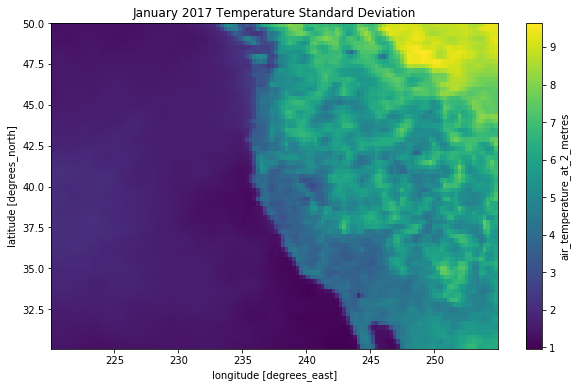

In [16]:
temp_std.plot(figsize=(10, 6))
plt.title('January 2017 Temperature Standard Deviation')

Now let's select various cities and plot their January temperature over time. 

In [17]:
# location coordinates
locs = [
    {'name': 'santa_barbara', 'lon': -119.6982, 'lat': 34.4208},
    {'name': 'colorado_springs', 'lon': -104.8214, 'lat': 38.8339},
    {'name': 'honolulu', 'lon': -157.835938, 'lat': 21.290014},
    {'name': 'seattle', 'lon': -122.3321, 'lat': 47.6062},
]

# convert westward longitudes to degrees east
for l in locs:
    if l['lon'] < 0:
        l['lon'] = 360 + l['lon']
locs

[{'name': 'santa_barbara', 'lon': 240.30180000000001, 'lat': 34.4208},
 {'name': 'colorado_springs', 'lon': 255.17860000000002, 'lat': 38.8339},
 {'name': 'honolulu', 'lon': 202.164062, 'lat': 21.290014},
 {'name': 'seattle', 'lon': 237.6679, 'lat': 47.6062}]

In [18]:
ds_locs = xr.Dataset()
air_temp_ds = air_temp.to_dataset()

# interate through the locations and create a dataset
# containing the temperature values for each location
for l in locs:
    name = l['name']
    lon = l['lon']
    lat = l['lat']
    var_name = name

    ds2 = air_temp_ds.sel(lon=lon, lat=lat, method='nearest')

    lon_attr = '%s_lon' % name
    lat_attr = '%s_lat' % name

    ds2.attrs[lon_attr] = ds2.lon.values.tolist()
    ds2.attrs[lat_attr] = ds2.lat.values.tolist()
#     ds2 = ds2.drop(('lat', 'lon'))
    ds2 = ds2.rename({var1 : var_name}).drop(('lat', 'lon'))

    ds_locs = xr.merge([ds_locs, ds2])

ds_locs.data_vars

Data variables:
    santa_barbara     (var, time0) float32 dask.array<shape=(1, 744), chunksize=(1, 744)>
    colorado_springs  (var, time0) float32 dask.array<shape=(1, 744), chunksize=(1, 744)>
    honolulu          (var, time0) float32 dask.array<shape=(1, 744), chunksize=(1, 744)>
    seattle           (var, time0) float32 dask.array<shape=(1, 744), chunksize=(1, 744)>

**Do some descriptive statistics**

In [19]:
df_f = ds_locs.to_dataframe()
df_f.describe()

,santa_barbara,colorado_springs,honolulu,seattle
count,744.000000,744.000000,744.000000,744.000000
mean,10.875379,-9.299802,18.269239,2.474147
std,2.871223,6.195022,1.441427,3.787661
min,4.898468,-25.948593,13.774048,-9.234039
25%,8.935883,-12.841469,17.158752,-0.221535
50%,10.693146,-9.239578,18.429993,2.714691
75%,12.570412,-4.989143,19.576767,5.212265
max,21.166656,3.263794,20.763336,11.018646


**Plot temperature across time for multiple cities**

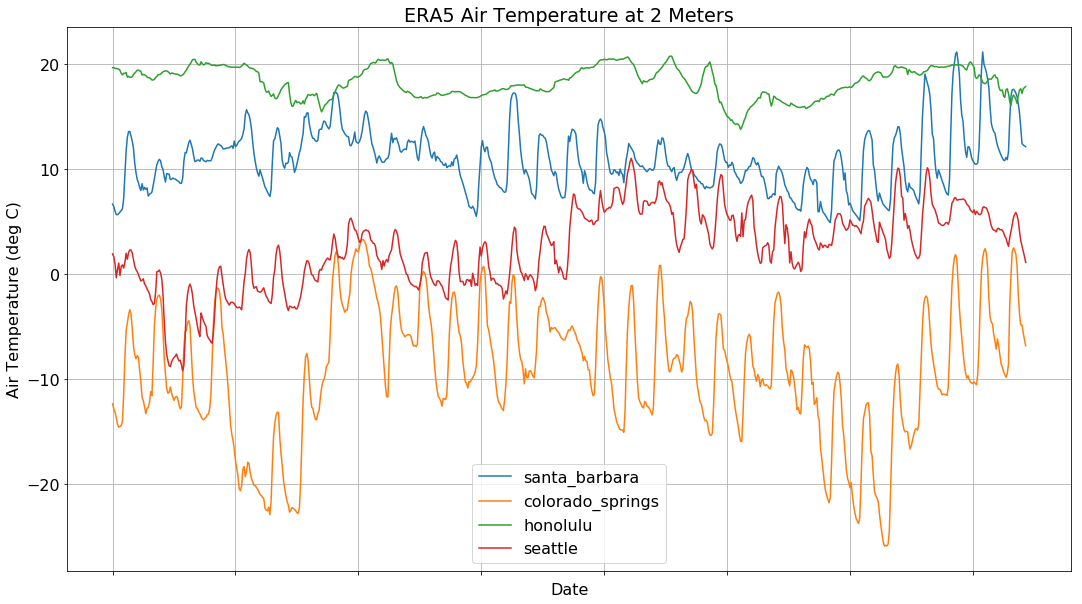

In [20]:
# readability please
plt.rcParams.update({'font.size': 16})

ax = df_f.plot(figsize=(18, 10), title="ERA5 Air Temperature at 2 Meters", grid=1)
ax.set(xlabel='Date', ylabel='Air Temperature (deg C)')
plt.show()